# Chapter: Fault Detection & Diagnosis via Unsupervised Artificial Neural Networks Modeling


# Topic: Semiconductor metal-etch fault detection using SOM

In [1]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

plt.rcParams.update({'font.size': 14})
np.random.seed(1)

In [2]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [3]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

In [4]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##               Fit PCA and use PC scores as model inputs
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
# scale data & fit PCA model via pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 3))])
score_train = pipe.fit_transform(unfolded_dataMatrix)

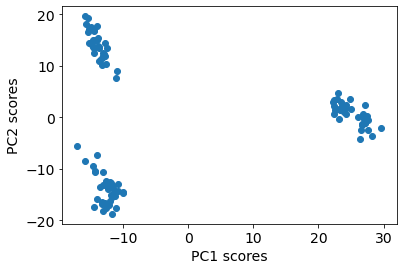

In [6]:
#  visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [7]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                           fit SOM model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from minisom import MiniSom    

N = score_train.shape[0]
N_neurons = 5*np.sqrt(N) 
som = MiniSom(np.floor(np.sqrt(N_neurons)).astype(int), np.floor(np.sqrt(N_neurons)).astype(int), score_train.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)
som.train(score_train, num_iteration=10000, verbose=True)

 [  2160 / 10000 ]  22% - 0:00:00 left 

 [  3891 / 10000 ]  39% - 0:00:00 left 

 [  5890 / 10000 ]  59% - 0:00:00 left 

 [  7889 / 10000 ]  79% - 0:00:00 left 

 [  9888 / 10000 ]  99% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.232209451247638


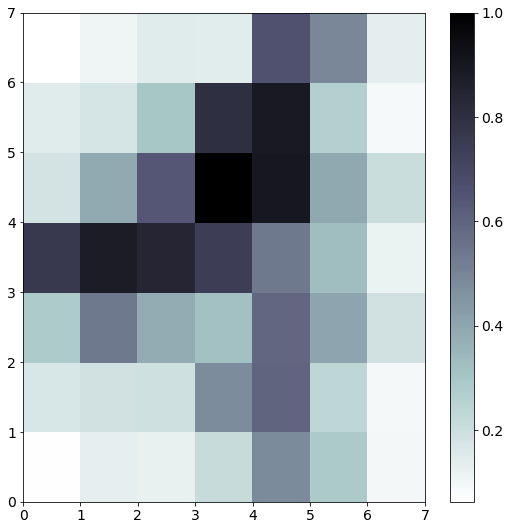

In [8]:
# plot U-matrix
plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()
plt.show()

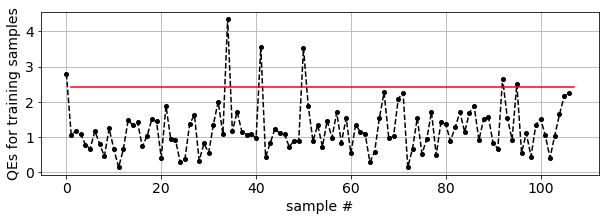

In [9]:
# s for training samples
QEs_train = np.linalg.norm(som.quantization(score_train) - score_train, axis=1)
QE_CL = np.percentile(QEs_train, 95)

# plot
plt.figure(figsize=(10,3))
plt.plot(QEs_train,'--',marker='o', markersize=4, color='black')
plt.plot([1,len(QEs_train)],[QE_CL,QE_CL], color='red')
plt.xlabel('sample #'), plt.ylabel('QEs for training samples')
plt.grid()
plt.show()

In [10]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [11]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

In [12]:
# scale and perform PCA on faulty test data
score_test = pipe.transform(unfolded_TestdataMatrix)

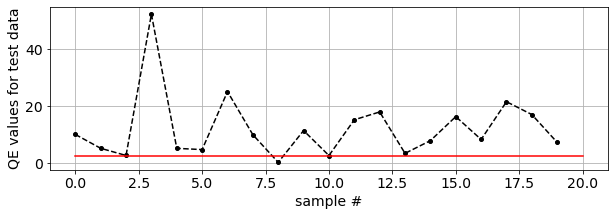

Number of flagged faults (using control chart):  19


In [13]:
# SOM test
QEs_test = np.linalg.norm(som.quantization(score_test) - score_test, axis=1)

# monitoring chart for test data
plt.figure(figsize=(10,3))
plt.plot(QEs_test,'--',marker='o', markersize=4, color='black')
plt.plot([0,len(QEs_test)],[QE_CL,QE_CL], color='red')
plt.xlabel('sample #'), plt.ylabel('QE values for test data')
plt.grid()
plt.show()

print('Number of flagged faults (using control chart): ', np.sum(QEs_test > QE_CL))

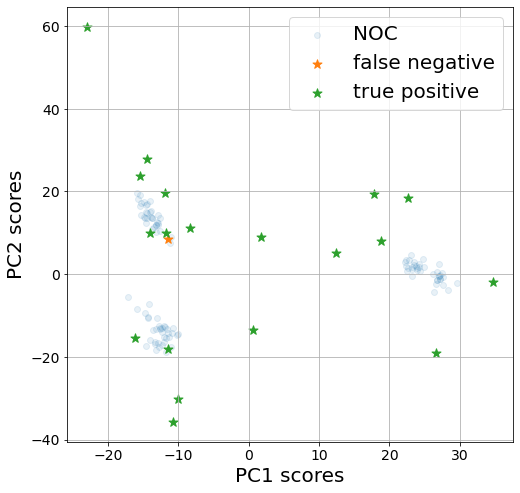

In [14]:
# check which test samples got flagged in 2D score space
is_faulty = QEs_test > QE_CL

plt.figure(figsize=(8, 8))
plt.scatter(score_train[:,0],score_train[:,1], label='NOC', alpha=0.1)
plt.scatter(score_test[~is_faulty, 0], score_test[~is_faulty, 1], marker='*', s=90, label='false negative')
plt.scatter(score_test[is_faulty, 0], score_test[is_faulty, 1], marker='*', s=90, label='true positive')
plt.xlabel('PC1 scores', fontsize=20)
plt.ylabel('PC2 scores', fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()